In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

from synthetic_data.perlin_noise import Perlin2D, Perlin2DMixture
from synthetic_data.depth_noise import Depth2D
from synthetic_data.blur import Blender

In [2]:
image_name = '0001_000216.png'

def show(images, titles, save=False):
    columns = len(images)
    fig = plt.figure(figsize=(10, 6))
    fig.tight_layout(pad=0.01)
    for i, (image, title) in enumerate(zip(images, titles), 1):
        fig.add_subplot(1, columns, i)
        plt.imshow(image)
        plt.axis('off')
        plt.title(title)
    titles = list(map(lambda x: x.replace(' ', '_'), titles))
    if save:
        plt.savefig('tmp_data/' + '_'.join(titles) + '.png', dpi=700)

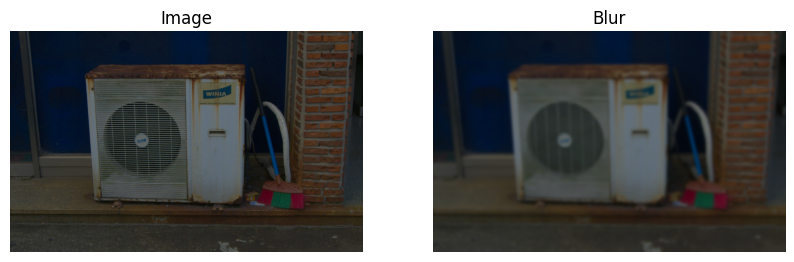

In [3]:
image = cv2.imread(f'raw_data/{image_name}')[..., ::-1] / 255

blur = Blender()
blured_image = blur(image, np.ones(image.shape[:-1]))

show([image, blured_image], ['Image', 'Blur'])

**Perlin Noise Generation Demo**

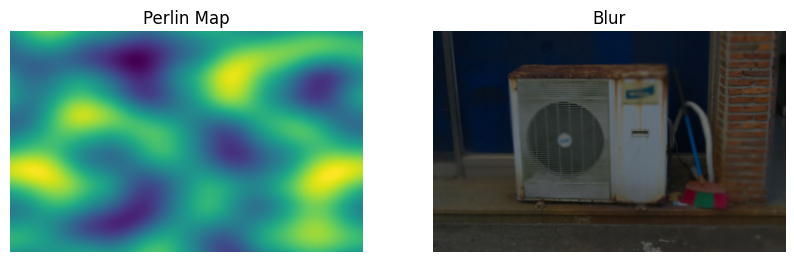

In [4]:
perlin_generator = Perlin2D()
perlin_map = perlin_generator(image)

show([perlin_map, blur(image, perlin_map)], ['Perlin Map', 'Blur'])

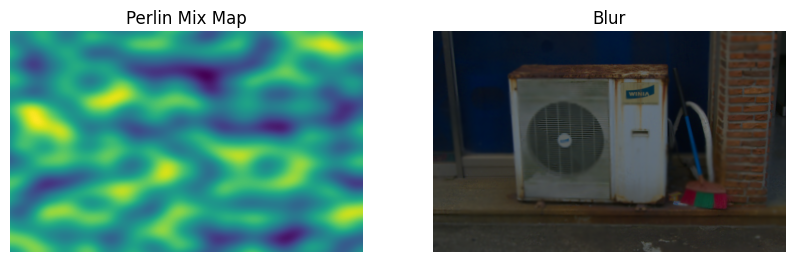

In [5]:
perlin_mix_generator = Perlin2DMixture(
    gen_shapes=[(256, 256), (256, 256), (256, 256)],
    gen_reses=[(2, 2), (4, 4), (8, 8)],
    gen_weights=[0.3, 0.5, 1]
)
perlin_mix_map = perlin_mix_generator(image)

show([perlin_mix_map, blur(image, perlin_mix_map)], ['Perlin Mix Map', 'Blur'])

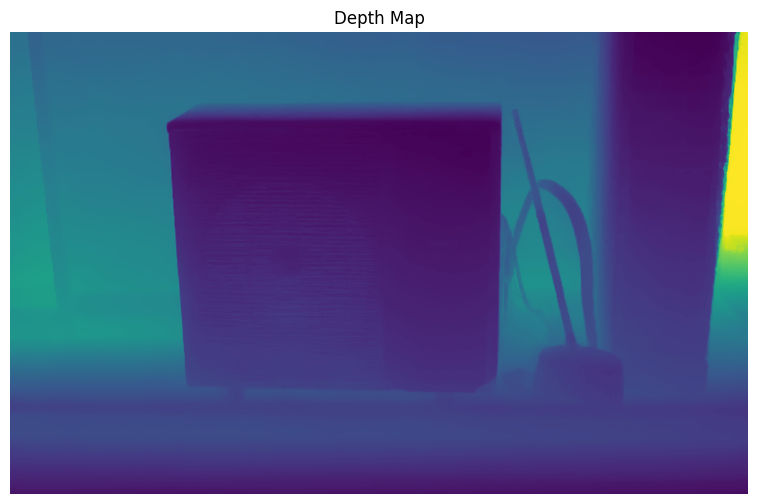

In [6]:
depth_image = cv2.imread(f'depth_data/depth_bw/{image_name[:-4]}_pred.png')[..., 0].astype(float) / 255
show([depth_image], ['Depth Map'])

**Depth Blur Generation Demo**

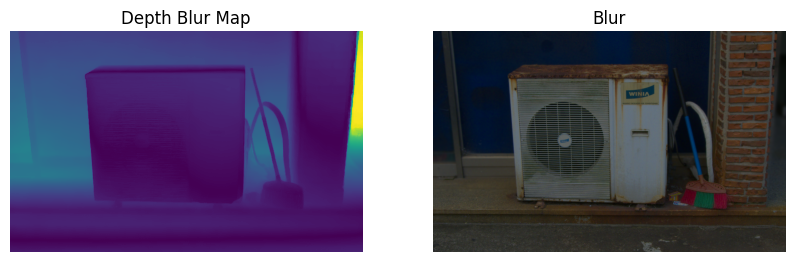

In [7]:
depth_generator = Depth2D(target_dist=0.13, focal_gamma=1.2)
depth_map = depth_generator(depth_image)
show([depth_map, blur(image, depth_map)], ['Depth Blur Map', 'Blur'])

**Mixed Blur Generation Demo**

/tmp/ipykernel_742005/1339808222.py:2: RuntimeWarning: divide by zero encountered in power
  mix_map = ((depth_map ** alpha) * (perlin_mix_map ** beta)) ** -(alpha + beta)
/home/26f_pri@lab.graphicon.ru/bread/synthetic_data/blur.py:57: RuntimeWarning: invalid value encountered in divide
  return np.clip(image / blend[..., None], 0, 1)
/home/26f_pri@lab.graphicon.ru/.local/lib/python3.10/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


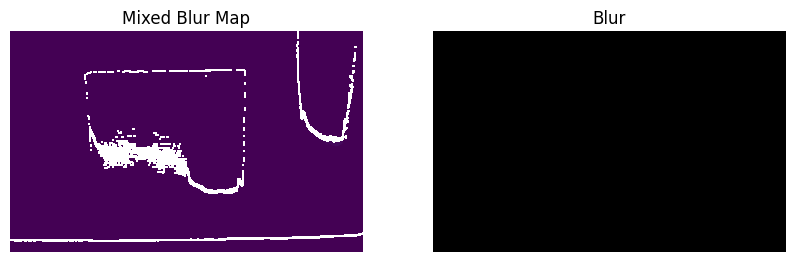

In [8]:
alpha, beta = 3.0, 0.5
mix_map = ((depth_map ** alpha) * (perlin_mix_map ** beta)) ** -(alpha + beta)
show([mix_map, blur(image, mix_map)], ['Mixed Blur Map', 'Blur'])

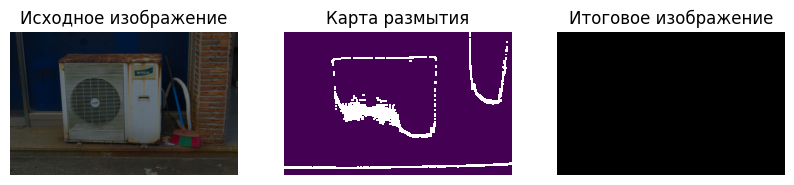

In [9]:
show([image, mix_map, blur(image, mix_map)], ['Исходное изображение', 'Карта размытия', 'Итоговое изображение'])

Секция Говнокода

In [ ]:
import os
import random
import tqdm
from scipy.stats import truncnorm
path = '/home/26f_pri@lab.graphicon.ru/RealBlurSlice'
paths = list(zip(filter(lambda x: x.endswith('.png'), sorted(os.listdir(path + '/gt'))), filter(lambda x: x.endswith('.png'), sorted(os.listdir(path + '/depth/depth_bw')))))

In [ ]:
blenders = [Blender(sigma=sigma, steps=10) for sigma in list(map(tuple, np.random.gamma(shape, scale, (13, 2))))]
depth_generator = Depth2D()
perlin_mix_generator = Perlin2DMixture(
    gen_shapes=[(256, 256), (256, 256), (256, 256)],
    gen_reses=[(2, 2), (4, 4), (8, 8)],
    gen_weights=[0.2, 0.5, 1]
)
for image_name, depth_name in tqdm.tqdm(paths):
    image = cv2.imread(f'{path}/gt/{image_name}')[..., ::-1].astype(float) / 255
    depth = cv2.imread(f'{path}/depth/depth_bw/{depth_name}')[..., 0].astype(float) / 255
    blender = random.choice(blenders)
    depth_map = depth_generator(depth, target_dist=truncnorm.rvs(0, 1, size=1)[0], focal_gamma=truncnorm.rvs(0.85, 1.3, size=1)[0])
    perlin_map = perlin_mix_generator(image)
    mix_map = (depth_map * perlin_map) ** 0.5
    result = blender(image, mix_map)
    cv2.imwrite(f'{path}/synt_blurhf/{image_name}', (result[..., ::-1] * 255).copy())

In [ ]:
def img2size(image, shape):
    return np.clip(cv2.resize(image, dsize=shape, interpolation=cv2.INTER_CUBIC), 0, 255)

def cprsz(src_dir, dst_dir):
    os.makedirs(dst_dir, exist_ok=True)
    for name in os.listdir(src_dir):
        if not name.endswith('.png'):
            continue
        image = cv2.imread(f'{src_dir}/{name}').astype(float)
        image = img2size(image, (512, 512))
        cv2.imwrite(f'{dst_dir}/{name}', image)

секция обучения

In [ ]:
import torch
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch import nn
import torch.nn.functional as F
import torchvision
from torchvision.io import read_image, ImageReadMode
import albumentations as A
import numpy as np
import tqdm
import os
import random

In [ ]:
class BlurDataset(Dataset):
    def __init__(self,  raw_dir, depth_dir, mode, val_split=0.15, seed=42):
        self.data = []
        self.raw_dir = raw_dir
        self.depth_dir = depth_dir
        random.seed(seed)
        for image in os.listdir(self.raw_dir):
            imgs_names = os.listdir(prefix_img
            random.shuffle(imgs_names)
            if mode == 'train':
                imgs_names = imgs_names[:-max(1, round(val_split * len(imgs_names)))]
            else:
                imgs_names = imgs_names[-max(1, round(val_split * len(imgs_names))):]
            inp = [f'{prefix_img}/{x}' for x in imgs_names]
            gt = [f'{prefix_gt}/{x[:-3]}png' for x in imgs_names]
            self.data.extend(list(zip(inp, gt)))
        random.shuffle(self.data)
    def __getitem__(self, index):
        image, gt = self.data[index]
        image = read_image(image, mode=ImageReadMode.RGB)
        gt = read_image(gt, mode=ImageReadMode.GRAY)
        pair = torch.cat([image, gt], dim=0)
        pair = self.COLORLESS_TRANSFORMS(pair)
        image, gt = pair[:3], pair[3:]
        image = self.COLORFUL_TRANSFORMS(image)
        gt = torch.cat([(1 - gt)[None, ...], gt[None, ...]], dim=0).squeeze()
        return image, gt
    def __len__(self):
        return len(self.data)
